In [8]:
!pip install "transformers" 
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import pandas as pd
import torch

In [10]:
data = pd.read_csv('/content/train.csv')
data

,text,label,language
0,wearing a fake engagement ring so guys won’t a...,1.8,English
1,Bees vs. Wasps. http,1.0,English
2,Here is a nice equation: 0+0-0-0+0=0,1.0,English
3,@user @user Enjoy each new day!😊🇨🇦🐞🐭,1.6,English
4,I can be having a perfectly good day then I th...,1.6,English
...,...,...,...
9486,若被確認為「國際關注公共衛生緊急事件」， 世衛會發布一系列包括確診、隔離和治療的詳細計畫， ...,1.0,Chinese
9487,@user 是嗎？ 可能我沒有注意到吧,2.0,Chinese
9488,@user @user 你剃过毛毛吗,3.8,Chinese
9489,@user 她没说是捐吧？,1.8,Chinese


In [11]:
data['language'].value_counts()

Portuguese    1596
Chinese       1596
Spanish       1592
French        1588
English       1587
Italian       1532
Name: language, dtype: int64

In [12]:
data['text'].apply(lambda x: len(x.split(' '))).describe()

count    9491.000000
mean        9.783690
std         6.087013
min         1.000000
25%         5.000000
50%         9.000000
75%        14.000000
max        34.000000
Name: text, dtype: float64

In [13]:
data['text']

0       wearing a fake engagement ring so guys won’t a...
1                                    Bees vs. Wasps. http
2                    Here is a nice equation: 0+0-0-0+0=0
3                    @user @user Enjoy each new day!😊🇨🇦🐞🐭
4       I can be having a perfectly good day then I th...
                              ...                        
9486    若被確認為「國際關注公共衛生緊急事件」， 世衛會發布一系列包括確診、隔離和治療的詳細計畫， ...
9487                                  @user 是嗎？ 可能我沒有注意到吧
9488                                   @user @user 你剃过毛毛吗
9489                                        @user 她没说是捐吧？
9490    通报来了 真的要消停一会了 视频不要私信要啦 就当2w粉的福利提前放出来吧 有风险勿模仿 感...
Name: text, Length: 9491, dtype: object

In [14]:
# Text cleaning (NEEDS WORK)


# can we use emojies, kisses indicating intimacy?
#what about hashtags, could hold info
# get rid of mentions @user @whatever
data['text'] = data['text'].str.replace(r'@[A-Za-z0-9_]+', '', regex=True)
# remove words containing numbers
data['text'] = data['text'].str.replace(r'\w*\d\w*', '', regex = True)


In [15]:
data['label'].min()

1.0

In [16]:
# lets solve like a classification problem for now
new_label = []
for i in range(data.shape[0]):
    if data['label'][i] < 2.0:
        new_label.append(1)
    elif data['label'][i] < 3.0:
        new_label.append(2)
    elif data['label'][i] < 4.0:
        new_label.append(3)
    else:
        new_label.append(4)
    
data['classification_label'] = new_label

In [17]:
data['classification_label'].value_counts()

1    4630
2    2970
3    1475
4     416
Name: classification_label, dtype: int64

In [18]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['encoded_labels'] = encoder.fit_transform(data.classification_label.values)
data

,text,label,language,classification_label,encoded_labels
0,wearing a fake engagement ring so guys won’t a...,1.8,English,1,0
1,Bees vs. Wasps. http,1.0,English,1,0
2,Here is a nice equation: +--+=,1.0,English,1,0
3,Enjoy each new day!😊🇨🇦🐞🐭,1.6,English,1,0
4,I can be having a perfectly good day then I th...,1.6,English,1,0
...,...,...,...,...,...
9486,若被確認為「國際關注公共衛生緊急事件」， 世衛會發布一系列包括確診、隔離和治療的詳細計畫， ...,1.0,Chinese,1,0
9487,是嗎？ 可能我沒有注意到吧,2.0,Chinese,2,1
9488,你剃过毛毛吗,3.8,Chinese,3,2
9489,她没说是捐吧？,1.8,Chinese,1,0


In [19]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-xlm-roberta-base')

Downloading:   0%|          | 0.00/652 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

max:  143
min:  2


(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 <a list of 7 Text major ticklabel objects>)

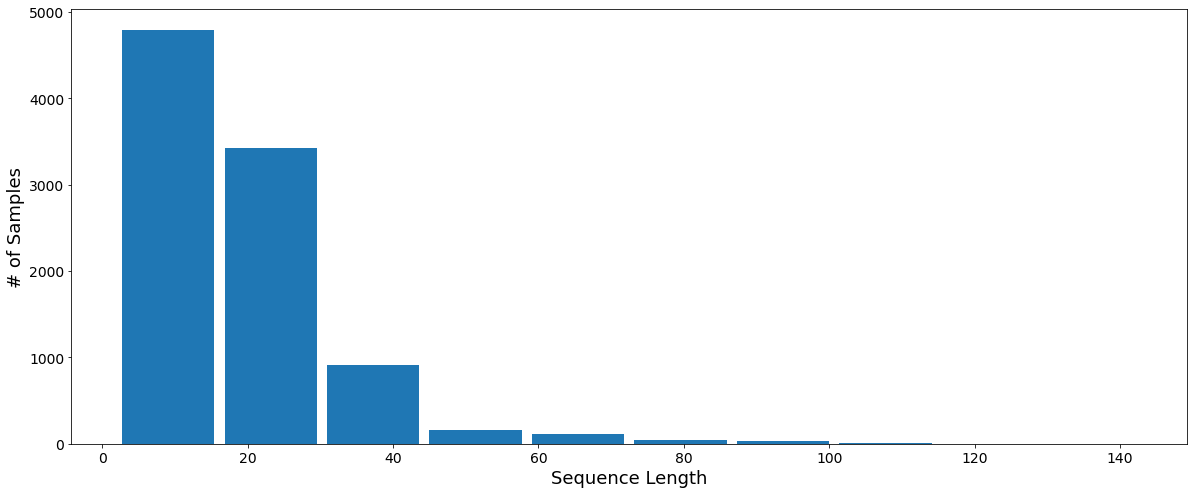

In [20]:
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            data.text.values.tolist(), 
                            add_special_tokens = True)


# collect tokenized sentence length 
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))

# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('# of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [21]:
train_text = data['text'].values.tolist()
train_target = data['encoded_labels'].values.tolist()

In [22]:
# tokenize

MAX_LEN = 128
train_tokenized_feature = tokenizer.batch_encode_plus(
                            train_text, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            padding = 'max_length',
                            truncation=True,
                            max_length = MAX_LEN, 
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt')

In [23]:
train_tokenized_feature

{'input_ids': tensor([[     0, 179493,     10,  ...,      1,      1,      1],
        [     0,    873,     90,  ...,      1,      1,      1],
        [     0,  11853,     83,  ...,      1,      1,      1],
        ...,
        [     0,  73675, 243389,  ...,      1,      1,      1],
        [     0, 115316,   7064,  ...,      1,      1,      1],
        [     0,      6, 173867,  ...,      1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [24]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(train_tokenized_feature['input_ids'], train_target,train_tokenized_feature['attention_mask'],random_state=2018, test_size=0.2)

In [25]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import RandomSampler, SequentialSampler


batch_size = 64


train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


In [26]:

validation_data = TensorDataset(validation_inputs, validation_masks, torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [28]:
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup

model = XLMRobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base", num_labels = 4, output_attentions = False,output_hidden_states = False)

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.den

In [29]:
model.resize_token_embeddings(len(tokenizer))

Embedding(250002, 768, padding_idx=1)

In [30]:
optimizer = AdamW(model.parameters(),
                  lr = 0.001, 
                  eps = 1e-8)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [31]:
epochs = 4
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [32]:
model.cuda()

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [33]:
# Training
import time
# Store the average loss after each epoch 
loss_values = []
# number of total steps for each epoch
print('total steps per epoch: ',  len(train_dataloader) / batch_size)
# looping over epochs
for epoch_i in range(0, epochs):
    
    print('training on epoch: ', epoch_i)
    # set start time 
    t0 = time.time()
    # reset total loss
    total_loss = 0
    # model in training 
    model.train()
    # loop through batch 
    for step, batch in enumerate(train_dataloader):
        # Progress update every 50 step 
        if step % 50 == 0 and not step == 0:
            print('training on step: ', step)
            print('total time used is: {0:.2f} s'.format(time.time() - t0))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        # clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)    
    loss_values.append(avg_train_loss)
    print("average training loss: {0:.2f}".format(avg_train_loss))

total steps per epoch:  1.859375
training on epoch:  0
training on step:  50
total time used is: 22.91 s
training on step:  100
total time used is: 44.06 s
average training loss: 1.39
training on epoch:  1
training on step:  50
total time used is: 21.60 s
training on step:  100
total time used is: 43.66 s
average training loss: 1.39
training on epoch:  2
training on step:  50
total time used is: 22.80 s
training on step:  100
total time used is: 46.05 s
average training loss: 1.39
training on epoch:  3
training on step:  50
total time used is: 22.90 s
training on step:  100
total time used is: 45.87 s
average training loss: 1.39
